In [37]:
import sys
import os
#connect local PATH
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

p = os.path.abspath(r'C:\Users\Ben\Desktop\Diplomatiki')
sys.path.append(str(p))

from CryptoSent.tools import utils as cs
from CryptoSent.tools import models as cm

In [5]:
p=r'C:\Users\Ben\Desktop\Diplomatiki\CryptoSent\Datasets\Main Dataset\submissions.pickle'
df=pd.read_pickle(p)

In [6]:
df=df[df.subreddit=='Bitcoin']

In [36]:
df=df.sort_values(by='score',ascending=False)

In [42]:
top=df.head(1000)

In [43]:
top['fin_bert']=top.title.progress_apply(cm.fin_bert)

100%|██████████| 1000/1000 [00:55<00:00, 18.05it/s]
C:\Users\Ben\anaconda3\envs\CryptoSent\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [45]:
top['pos']=top.fin_bert.apply(lambda x: x[0])
top['neg']=top.fin_bert.apply(lambda x: x[1])
top['neut']=top.fin_bert.apply(lambda x: x[2])

C:\Users\Ben\anaconda3\envs\CryptoSent\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Ben\anaconda3\envs\CryptoSent\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Ben\anaconda3\envs\CryptoSent\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

<AxesSubplot:xlabel='created'>

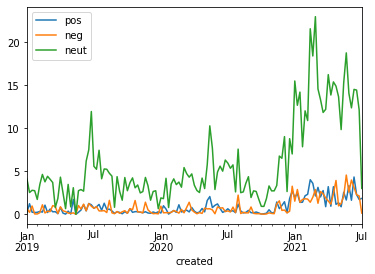

In [49]:
top[['pos','neg','neut']].resample('w').sum().plot()

In [50]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [93]:
dchunk='d'
a=top.resample(dchunk).sum()[['neg','pos','neut']]
btc_price=pd.read_csv(r"C:\Users\Ben\Desktop\Diplomatiki\CryptoSent\Datasets\other\coin_Bitcoin.csv")
btc_price.Date=pd.to_datetime(btc_price.Date)
btc_price=btc_price.set_index('Date')
btc_price['avg_price']=(btc_price.High+btc_price.Low)/2

btc_price_avg=btc_price.resample(dchunk).mean().loc['2019':'2021-06']['avg_price']

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=a.index, y=a.pos-a.neg, name="Sentiment"),
    secondary_y=False,
)


fig.add_trace(
    go.Scatter(x=btc_price_avg.index, y=btc_price_avg.diff(), name="Bit Coin Avg"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="BTC vs LR Sentiment Model - Weekly"
)

# Set x-axis title
fig.update_xaxes(title_text="Date")

# Set y-axes titles
fig.update_yaxes(title_text="<b>Sentiment Polarity </b>", secondary_y=False)
fig.update_yaxes(title_text="<b>BTC Price</b>", secondary_y=True)

fig.show()

In [63]:
from statsmodels.tsa.stattools import adfuller

def adf_test(df):
    result = adfuller(df.values)
    print('ADF Statistics: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [83]:
print('Negative')
adf_test(a.neg)
print('Positive')
adf_test(a.pos)
print('Neutural')
adf_test(a.neut)

Negative
ADF Statistics: -1.601826
p-value: 0.482676
Critical values:
	1%: -3.445
	5%: -2.868
	10%: -2.570
Positive
ADF Statistics: -1.041458
p-value: 0.737845
Critical values:
	1%: -3.445
	5%: -2.868
	10%: -2.570
Neutural
ADF Statistics: -1.626460
p-value: 0.469344
Critical values:
	1%: -3.445
	5%: -2.868
	10%: -2.570


In [86]:
from statsmodels.tsa.stattools import grangercausalitytests
import numpy as np
maxlag=15
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
   
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df



In [113]:
btc=btc_price_avg.diff().dropna()
btc

Date
2019-01-02     103.622851
2019-01-03      -1.741384
2019-01-04     -56.059902
2019-01-05      46.007512
2019-01-06      89.003642
                 ...     
2021-06-26   -2008.021437
2021-06-27    1952.897758
2021-06-28    1197.041590
2021-06-29     836.314113
2021-06-30    -316.842137
Freq: D, Name: avg_price, Length: 911, dtype: float64

In [114]:
ga=a.dropna()
ga.index.names = ['Date']


In [115]:
ga=ga.merge(btc,left_index=True,right_index=True)

In [120]:

grangers_causation_matrix(ga, variables = ga.columns)

,neg_x,pos_x,neut_x,avg_price_x,sent_x
neg_y,1.0000,0.0000,0.0000,0.0001,0.0000
pos_y,0.0000,1.0000,0.0000,0.0000,0.0000
neut_y,0.0001,0.0000,1.0000,0.0013,0.0664
avg_price_y,0.0530,0.0067,0.0205,1.0000,0.0316
sent_y,0.3030,0.3030,0.0016,0.0000,1.0000


In [198]:
qq=ga[ga.sent!=0]

In [199]:
qq

,neg,pos,neut,avg_price,sent
Date,,,,,
2019-01-03,0.176074,0.115174,1.708753,-1.741384,-0.060900
2019-01-04,0.419860,0.073753,1.506387,-56.059902,-0.346107
2019-01-06,0.063720,0.037901,0.898379,89.003642,-0.025819
2019-01-08,0.042418,0.412482,0.545100,-3.765533,0.370064
2019-01-09,0.050251,0.784685,1.165064,-7.454966,0.734434
...,...,...,...,...,...
2021-06-26,0.021614,0.049219,0.929167,-2008.021437,0.027604
2021-06-27,0.038259,0.625497,1.336245,1952.897758,0.587238
2021-06-28,0.010002,0.118183,0.871815,1197.041590,0.108181


In [205]:
grangercausalitytests(qq[['sent','avg_price']],maxlag=30)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.0181  , p=0.0455  , df_denom=576, df_num=1
ssr based chi2 test:   chi2=4.0391  , p=0.0445  , df=1
likelihood ratio test: chi2=4.0250  , p=0.0448  , df=1
parameter F test:         F=4.0181  , p=0.0455  , df_denom=576, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.7206  , p=0.0093  , df_denom=573, df_num=2
ssr based chi2 test:   chi2=9.5235  , p=0.0086  , df=2
likelihood ratio test: chi2=9.4459  , p=0.0089  , df=2
parameter F test:         F=4.7206  , p=0.0093  , df_denom=573, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.9904  , p=0.0020  , df_denom=570, df_num=3
ssr based chi2 test:   chi2=15.1550 , p=0.0017  , df=3
likelihood ratio test: chi2=14.9594 , p=0.0019  , df=3
parameter F test:         F=4.9904  , p=0.0020  , df_denom=570, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.3331  , p=0.0018  

{1: ({'ssr_ftest': (4.018140372321272, 0.045480892850057714, 576.0, 1),
   'ssr_chi2test': (4.039068186760446, 0.04445836315493673, 1),
   'lrtest': (4.025045219636695, 0.04482941805634296, 1),
   'params_ftest': (4.01814037232121, 0.045480892850057714, 576.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (4.720558715059396, 0.009259629895419029, 573.0, 2),
   'ssr_chi2test': (9.523500653767298, 0.008550629894432563, 2),
   'lrtest': (9.445894286733619, 0.008888942918187894, 2),
   'params_ftest': (4.7205587150591715, 0.009259629895421093, 573.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (4.990389957724367, 0.0020043815893312175, 570.0, 3),
   'ssr_chi2test': (15.155026345299786, 0.0016888480801433856, 3),
   'lrtest': (14.959419085284026, 0.0018516585883349705, 3),
   'params_ftest': (4.9903899577224715, 0.0020043815893365405, 570.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
      

In [206]:
www=			{
				"mimeType": "application/vnd.code.notebook.stdout",
				"data": "\nGranger Causality\nnumber of lags (no zero) 1\nssr based F test:         F=4.0181  , p=0.0455  , df_denom=576, df_num=1\nssr based chi2 test:   chi2=4.0391  , p=0.0445  , df=1\nlikelihood ratio test: chi2=4.0250  , p=0.0448  , df=1\nparameter F test:         F=4.0181  , p=0.0455  , df_denom=576, df_num=1\n\nGranger Causality\nnumber of lags (no zero) 2\nssr based F test:         F=4.7206  , p=0.0093  , df_denom=573, df_num=2\nssr based chi2 test:   chi2=9.5235  , p=0.0086  , df=2\nlikelihood ratio test: chi2=9.4459  , p=0.0089  , df=2\nparameter F test:         F=4.7206  , p=0.0093  , df_denom=573, df_num=2\n\nGranger Causality\nnumber of lags (no zero) 3\nssr based F test:         F=4.9904  , p=0.0020  , df_denom=570, df_num=3\nssr based chi2 test:   chi2=15.1550 , p=0.0017  , df=3\nlikelihood ratio test: chi2=14.9594 , p=0.0019  , df=3\nparameter F test:         F=4.9904  , p=0.0020  , df_denom=570, df_num=3\n\nGranger Causality\nnumber of lags (no zero) 4\nssr based F test:         F=4.3331  , p=0.0018  , df_denom=567, df_num=4\nssr based chi2 test:   chi2=17.6074 , p=0.0015  , df=4\nlikelihood ratio test: chi2=17.3436 , p=0.0017  , df=4\nparameter F test:         F=4.3331  , p=0.0018  , df_denom=567, df_num=4\n\nGranger Causality\nnumber of lags (no zero) 5\nssr based F test:         F=3.5764  , p=0.0034  , df_denom=564, df_num=5\nssr based chi2 test:   chi2=18.2305 , p=0.0027  , df=5\nlikelihood ratio test: chi2=17.9475 , p=0.0030  , df=5\nparameter F test:         F=3.5764  , p=0.0034  , df_denom=564, df_num=5\n\nGranger Causality\nnumber of lags (no zero) 6\nssr based F test:         F=5.1375  , p=0.0000  , df_denom=561, df_num=6\nssr based chi2 test:   chi2=31.5394 , p=0.0000  , df=6\nlikelihood ratio test: chi2=30.7034 , p=0.0000  , df=6\nparameter F test:         F=5.1375  , p=0.0000  , df_denom=561, df_num=6\n\nGranger Causality\nnumber of lags (no zero) 7\nssr based F test:         F=4.4348  , p=0.0001  , df_denom=558, df_num=7\nssr based chi2 test:   chi2=31.8782 , p=0.0000  , df=7\nlikelihood ratio test: chi2=31.0230 , p=0.0001  , df=7\nparameter F test:         F=4.4348  , p=0.0001  , df_denom=558, df_num=7\n\nGranger Causality\nnumber of lags (no zero) 8\nssr based F test:         F=4.0310  , p=0.0001  , df_denom=555, df_num=8\nssr based chi2 test:   chi2=33.2357 , p=0.0001  , df=8\nlikelihood ratio test: chi2=32.3059 , p=0.0001  , df=8\nparameter F test:         F=4.0310  , p=0.0001  , df_denom=555, df_num=8\n\nGranger Causality\nnumber of lags (no zero) 9\nssr based F test:         F=3.6024  , p=0.0002  , df_denom=552, df_num=9\nssr based chi2 test:   chi2=33.5378 , p=0.0001  , df=9\nlikelihood ratio test: chi2=32.5899 , p=0.0002  , df=9\nparameter F test:         F=3.6024  , p=0.0002  , df_denom=552, df_num=9\n\nGranger Causality\nnumber of lags (no zero) 10\nssr based F test:         F=3.2336  , p=0.0005  , df_denom=549, df_num=10\nssr based chi2 test:   chi2=33.5732 , p=0.0002  , df=10\nlikelihood ratio test: chi2=32.6217 , p=0.0003  , df=10\nparameter F test:         F=3.2336  , p=0.0005  , df_denom=549, df_num=10\n\nGranger Causality\nnumber of lags (no zero) 11\nssr based F test:         F=2.8069  , p=0.0014  , df_denom=546, df_num=11\nssr based chi2 test:   chi2=32.1769 , p=0.0007  , df=11\nlikelihood ratio test: chi2=31.3000 , p=0.0010  , df=11\nparameter F test:         F=2.8069  , p=0.0014  , df_denom=546, df_num=11\n\nGranger Causality\nnumber of lags (no zero) 12\nssr based F test:         F=2.7811  , p=0.0011  , df_denom=543, df_num=12\nssr based chi2 test:   chi2=34.9098 , p=0.0005  , df=12\nlikelihood ratio test: chi2=33.8791 , p=0.0007  , df=12\nparameter F test:         F=2.7811  , p=0.0011  , df_denom=543, df_num=12\n\nGranger Causality\nnumber of lags (no zero) 13\nssr based F test:         F=2.9115  , p=0.0004  , df_denom=540, df_num=13\nssr based chi2 test:   chi2=39.7419 , p=0.0002  , df=13\nlikelihood ratio test: chi2=38.4110 , p=0.0002  , df=13\nparameter F test:         F=2.9115  , p=0.0004  , df_denom=540, df_num=13\n\nGranger Causality\nnumber of lags (no zero) 14\nssr based F test:         F=2.7253  , p=0.0007  , df_denom=537, df_num=14\nssr based chi2 test:   chi2=40.2150 , p=0.0002  , df=14\nlikelihood ratio test: chi2=38.8506 , p=0.0004  , df=14\nparameter F test:         F=2.7253  , p=0.0007  , df_denom=537, df_num=14\n\nGranger Causality\nnumber of lags (no zero) 15\nssr based F test:         F=2.8632  , p=0.0002  , df_denom=534, df_num=15\nssr based chi2 test:   chi2=45.4420 , p=0.0001  , df=15\nlikelihood ratio test: chi2=43.7070 , p=0.0001  , df=15\nparameter F test:         F=2.8632  , p=0.0002  , df_denom=534, df_num=15\n\nGranger Causality\nnumber of lags (no zero) 16\nssr based F test:         F=3.7601  , p=0.0000  , df_denom=531, df_num=16\nssr based chi2 test:   chi2=63.9008 , p=0.0000  , df=16\nlikelihood ratio test: chi2=60.5330 , p=0.0000  , df=16\nparameter F test:         F=3.7601  , p=0.0000  , df_denom=531, df_num=16\n\nGranger Causality\nnumber of lags (no zero) 17\nssr based F test:         F=3.6294  , p=0.0000  , df_denom=528, df_num=17\nssr based chi2 test:   chi2=65.7904 , p=0.0000  , df=17\nlikelihood ratio test: chi2=62.2218 , p=0.0000  , df=17\nparameter F test:         F=3.6294  , p=0.0000  , df_denom=528, df_num=17\n\nGranger Causality\nnumber of lags (no zero) 18\nssr based F test:         F=3.6736  , p=0.0000  , df_denom=525, df_num=18\nssr based chi2 test:   chi2=70.7857 , p=0.0000  , df=18\nlikelihood ratio test: chi2=66.6700 , p=0.0000  , df=18\nparameter F test:         F=3.6736  , p=0.0000  , df_denom=525, df_num=18\n\nGranger Causality\nnumber of lags (no zero) 19\nssr based F test:         F=3.4923  , p=0.0000  , df_denom=522, df_num=19\nssr based chi2 test:   chi2=71.3105 , p=0.0000  , df=19\nlikelihood ratio test: chi2=67.1291 , p=0.0000  , df=19\nparameter F test:         F=3.4923  , p=0.0000  , df_denom=522, df_num=19\n\nGranger Causality\nnumber of lags (no zero) 20\nssr based F test:         F=3.2613  , p=0.0000  , df_denom=519, df_num=20\nssr based chi2 test:   chi2=70.3797 , p=0.0000  , df=20\nlikelihood ratio test: chi2=66.2959 , p=0.0000  , df=20\nparameter F test:         F=3.2613  , p=0.0000  , df_denom=519, df_num=20\n\nGranger Causality\nnumber of lags (no zero) 21\nssr based F test:         F=3.3971  , p=0.0000  , df_denom=516, df_num=21\nssr based chi2 test:   chi2=77.2843 , p=0.0000  , df=21\nlikelihood ratio test: chi2=72.3883 , p=0.0000  , df=21\nparameter F test:         F=3.3971  , p=0.0000  , df_denom=516, df_num=21\n\nGranger Causality\nnumber of lags (no zero) 22\nssr based F test:         F=3.3114  , p=0.0000  , df_denom=513, df_num=22\nssr based chi2 test:   chi2=79.2409 , p=0.0000  , df=22\nlikelihood ratio test: chi2=74.0961 , p=0.0000  , df=22\nparameter F test:         F=3.3114  , p=0.0000  , df_denom=513, df_num=22\n\nGranger Causality\nnumber of lags (no zero) 23\nssr based F test:         F=3.1777  , p=0.0000  , df_denom=510, df_num=23\nssr based chi2 test:   chi2=79.8230 , p=0.0000  , df=23\nlikelihood ratio test: chi2=74.5971 , p=0.0000  , df=23\nparameter F test:         F=3.1777  , p=0.0000  , df_denom=510, df_num=23\n\nGranger Causality\nnumber of lags (no zero) 24\nssr based F test:         F=3.0485  , p=0.0000  , df_denom=507, df_num=24\nssr based chi2 test:   chi2=80.2353 , p=0.0000  , df=24\nlikelihood ratio test: chi2=74.9489 , p=0.0000  , df=24\nparameter F test:         F=3.0485  , p=0.0000  , df_denom=507, df_num=24\n\nGranger Causality\nnumber of lags (no zero) 25\nssr based F test:         F=3.0009  , p=0.0000  , df_denom=504, df_num=25\nssr based chi2 test:   chi2=82.6142 , p=0.0000  , df=25\nlikelihood ratio test: chi2=77.0147 , p=0.0000  , df=25\nparameter F test:         F=3.0009  , p=0.0000  , df_denom=504, df_num=25\n\nGranger Causality\nnumber of lags (no zero) 26\nssr based F test:         F=2.7647  , p=0.0000  , df_denom=501, df_num=26\nssr based chi2 test:   chi2=79.4864 , p=0.0000  , df=26\nlikelihood ratio test: chi2=74.2769 , p=0.0000  , df=26\nparameter F test:         F=2.7647  , p=0.0000  , df_denom=501, df_num=26\n\nGranger Causality\nnumber of lags (no zero) 27\nssr based F test:         F=2.6887  , p=0.0000  , df_denom=498, df_num=27\nssr based chi2 test:   chi2=80.6121 , p=0.0000  , df=27\nlikelihood ratio test: chi2=75.2517 , p=0.0000  , df=27\nparameter F test:         F=2.6887  , p=0.0000  , df_denom=498, df_num=27\n\nGranger Causality\nnumber of lags (no zero) 28\nssr based F test:         F=2.6011  , p=0.0000  , df_denom=495, df_num=28\nssr based chi2 test:   chi2=81.2160 , p=0.0000  , df=28\nlikelihood ratio test: chi2=75.7695 , p=0.0000  , df=28\nparameter F test:         F=2.6011  , p=0.0000  , df_denom=495, df_num=28\n\nGranger Causality\nnumber of lags (no zero) 29\nssr based F test:         F=2.5916  , p=0.0000  , df_denom=492, df_num=29\nssr based chi2 test:   chi2=84.1688 , p=0.0000  , df=29\nlikelihood ratio test: chi2=78.3279 , p=0.0000  , df=29\nparameter F test:         F=2.5916  , p=0.0000  , df_denom=492, df_num=29\n\nGranger Causality\nnumber of lags (no zero) 30\nssr based F test:         F=2.6146  , p=0.0000  , df_denom=489, df_num=30\nssr based chi2 test:   chi2=88.2212 , p=0.0000  , df=30\nlikelihood ratio test: chi2=81.8217 , p=0.0000  , df=30\nparameter F test:         F=2.6146  , p=0.0000  , df_denom=489, df_num=30\n"
			}

In [209]:
print(www['data'])


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.0181  , p=0.0455  , df_denom=576, df_num=1
ssr based chi2 test:   chi2=4.0391  , p=0.0445  , df=1
likelihood ratio test: chi2=4.0250  , p=0.0448  , df=1
parameter F test:         F=4.0181  , p=0.0455  , df_denom=576, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.7206  , p=0.0093  , df_denom=573, df_num=2
ssr based chi2 test:   chi2=9.5235  , p=0.0086  , df=2
likelihood ratio test: chi2=9.4459  , p=0.0089  , df=2
parameter F test:         F=4.7206  , p=0.0093  , df_denom=573, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.9904  , p=0.0020  , df_denom=570, df_num=3
ssr based chi2 test:   chi2=15.1550 , p=0.0017  , df=3
likelihood ratio test: chi2=14.9594 , p=0.0019  , df=3
parameter F test:         F=4.9904  , p=0.0020  , df_denom=570, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.3331  , p=0.0018  

In [210]:
grangercausalitytests(qq[['avg_price','sent']],maxlag=30)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0503  , p=0.8226  , df_denom=576, df_num=1
ssr based chi2 test:   chi2=0.0506  , p=0.8220  , df=1
likelihood ratio test: chi2=0.0506  , p=0.8220  , df=1
parameter F test:         F=0.0503  , p=0.8226  , df_denom=576, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1827  , p=0.8331  , df_denom=573, df_num=2
ssr based chi2 test:   chi2=0.3686  , p=0.8317  , df=2
likelihood ratio test: chi2=0.3685  , p=0.8317  , df=2
parameter F test:         F=0.1827  , p=0.8331  , df_denom=573, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1367  , p=0.9381  , df_denom=570, df_num=3
ssr based chi2 test:   chi2=0.4152  , p=0.9371  , df=3
likelihood ratio test: chi2=0.4150  , p=0.9371  , df=3
parameter F test:         F=0.1367  , p=0.9381  , df_denom=570, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.0765  , p=0.9894  

{1: ({'ssr_ftest': (0.05032801906798377, 0.8225730298922472, 576.0, 1),
   'ssr_chi2test': (0.050590144167296194, 0.822039542499774, 1),
   'lrtest': (0.05058793413627427, 0.8220433645373284, 1),
   'params_ftest': (0.05032801906797866, 0.8225730298922472, 576.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.18269829147234973, 0.8330679531311422, 573.0, 2),
   'ssr_chi2test': (0.36858503480285565, 0.8316924837165998, 2),
   'lrtest': (0.36846756317754625, 0.8317413352851639, 2),
   'params_ftest': (0.1826982914724184, 0.8330679531311156, 573.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.13670726540128597, 0.9380996254208237, 570.0, 3),
   'ssr_chi2test': (0.41515837966601055, 0.9370936313656199, 3),
   'lrtest': (0.41500909556816623, 0.9371248100067849, 3),
   'params_ftest': (0.13670726540125208, 0.9380996254208368, 570.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0

In [213]:
www1=	[		{
				"mimeType": "application/vnd.code.notebook.stdout",
				"data": "\nGranger Causality\nnumber of lags (no zero) 1\nssr based F test:         F=0.0503  , p=0.8226  , df_denom=576, df_num=1\nssr based chi2 test:   chi2=0.0506  , p=0.8220  , df=1\nlikelihood ratio test: chi2=0.0506  , p=0.8220  , df=1\nparameter F test:         F=0.0503  , p=0.8226  , df_denom=576, df_num=1\n\nGranger Causality\nnumber of lags (no zero) 2\nssr based F test:         F=0.1827  , p=0.8331  , df_denom=573, df_num=2\nssr based chi2 test:   chi2=0.3686  , p=0.8317  , df=2\nlikelihood ratio test: chi2=0.3685  , p=0.8317  , df=2\nparameter F test:         F=0.1827  , p=0.8331  , df_denom=573, df_num=2\n\nGranger Causality\nnumber of lags (no zero) 3\nssr based F test:         F=0.1367  , p=0.9381  , df_denom=570, df_num=3\nssr based chi2 test:   chi2=0.4152  , p=0.9371  , df=3\nlikelihood ratio test: chi2=0.4150  , p=0.9371  , df=3\nparameter F test:         F=0.1367  , p=0.9381  , df_denom=570, df_num=3\n\nGranger Causality\nnumber of lags (no zero) 4\nssr based F test:         F=0.0765  , p=0.9894  , df_denom=567, df_num=4\nssr based chi2 test:   chi2=0.3110  , p=0.9891  , df=4\nlikelihood ratio test: chi2=0.3110  , p=0.9891  , df=4\nparameter F test:         F=0.0765  , p=0.9894  , df_denom=567, df_num=4\n\nGranger Causality\nnumber of lags (no zero) 5\nssr based F test:         F=0.1938  , p=0.9649  , df_denom=564, df_num=5\nssr based chi2 test:   chi2=0.9877  , p=0.9636  , df=5\nlikelihood ratio test: chi2=0.9869  , p=0.9636  , df=5\nparameter F test:         F=0.1938  , p=0.9649  , df_denom=564, df_num=5\n\nGranger Causality\nnumber of lags (no zero) 6\nssr based F test:         F=0.7188  , p=0.6346  , df_denom=561, df_num=6\nssr based chi2 test:   chi2=4.4125  , p=0.6210  , df=6\nlikelihood ratio test: chi2=4.3956  , p=0.6233  , df=6\nparameter F test:         F=0.7188  , p=0.6346  , df_denom=561, df_num=6\n\nGranger Causality\nnumber of lags (no zero) 7\nssr based F test:         F=0.8030  , p=0.5850  , df_denom=558, df_num=7\nssr based chi2 test:   chi2=5.7721  , p=0.5666  , df=7\nlikelihood ratio test: chi2=5.7432  , p=0.5700  , df=7\nparameter F test:         F=0.8030  , p=0.5850  , df_denom=558, df_num=7\n\nGranger Causality\nnumber of lags (no zero) 8\nssr based F test:         F=1.0046  , p=0.4313  , df_denom=555, df_num=8\nssr based chi2 test:   chi2=8.2829  , p=0.4063  , df=8\nlikelihood ratio test: chi2=8.2235  , p=0.4119  , df=8\nparameter F test:         F=1.0046  , p=0.4313  , df_denom=555, df_num=8\n\nGranger Causality\nnumber of lags (no zero) 9\nssr based F test:         F=0.9750  , p=0.4596  , df_denom=552, df_num=9\nssr based chi2 test:   chi2=9.0769  , p=0.4302  , df=9\nlikelihood ratio test: chi2=9.0056  , p=0.4368  , df=9\nparameter F test:         F=0.9750  , p=0.4596  , df_denom=552, df_num=9\n\nGranger Causality\nnumber of lags (no zero) 10\nssr based F test:         F=0.8074  , p=0.6217  , df_denom=549, df_num=10\nssr based chi2 test:   chi2=8.3826  , p=0.5915  , df=10\nlikelihood ratio test: chi2=8.3215  , p=0.5975  , df=10\nparameter F test:         F=0.8074  , p=0.6217  , df_denom=549, df_num=10\n\nGranger Causality\nnumber of lags (no zero) 11\nssr based F test:         F=0.6188  , p=0.8134  , df_denom=546, df_num=11\nssr based chi2 test:   chi2=7.0938  , p=0.7914  , df=11\nlikelihood ratio test: chi2=7.0499  , p=0.7950  , df=11\nparameter F test:         F=0.6188  , p=0.8134  , df_denom=546, df_num=11\n\nGranger Causality\nnumber of lags (no zero) 12\nssr based F test:         F=0.4470  , p=0.9438  , df_denom=543, df_num=12\nssr based chi2 test:   chi2=5.6106  , p=0.9344  , df=12\nlikelihood ratio test: chi2=5.5831  , p=0.9356  , df=12\nparameter F test:         F=0.4470  , p=0.9438  , df_denom=543, df_num=12\n\nGranger Causality\nnumber of lags (no zero) 13\nssr based F test:         F=0.4117  , p=0.9659  , df_denom=540, df_num=13\nssr based chi2 test:   chi2=5.6191  , p=0.9589  , df=13\nlikelihood ratio test: chi2=5.5914  , p=0.9598  , df=13\nparameter F test:         F=0.4117  , p=0.9659  , df_denom=540, df_num=13\n\nGranger Causality\nnumber of lags (no zero) 14\nssr based F test:         F=0.3847  , p=0.9791  , df_denom=537, df_num=14\nssr based chi2 test:   chi2=5.6760  , p=0.9740  , df=14\nlikelihood ratio test: chi2=5.6478  , p=0.9746  , df=14\nparameter F test:         F=0.3847  , p=0.9791  , df_denom=537, df_num=14\n\nGranger Causality\nnumber of lags (no zero) 15\nssr based F test:         F=0.6010  , p=0.8750  , df_denom=534, df_num=15\nssr based chi2 test:   chi2=9.5377  , p=0.8478  , df=15\nlikelihood ratio test: chi2=9.4581  , p=0.8524  , df=15\nparameter F test:         F=0.6010  , p=0.8750  , df_denom=534, df_num=15\n\nGranger Causality\nnumber of lags (no zero) 16\nssr based F test:         F=0.5737  , p=0.9041  , df_denom=531, df_num=16\nssr based chi2 test:   chi2=9.7489  , p=0.8794  , df=16\nlikelihood ratio test: chi2=9.6656  , p=0.8835  , df=16\nparameter F test:         F=0.5737  , p=0.9041  , df_denom=531, df_num=16\n\nGranger Causality\nnumber of lags (no zero) 17\nssr based F test:         F=0.6125  , p=0.8834  , df_denom=528, df_num=17\nssr based chi2 test:   chi2=11.1021 , p=0.8512  , df=17\nlikelihood ratio test: chi2=10.9941 , p=0.8569  , df=17\nparameter F test:         F=0.6125  , p=0.8834  , df_denom=528, df_num=17\n\nGranger Causality\nnumber of lags (no zero) 18\nssr based F test:         F=0.6022  , p=0.8989  , df_denom=525, df_num=18\nssr based chi2 test:   chi2=11.6032 , p=0.8670  , df=18\nlikelihood ratio test: chi2=11.4851 , p=0.8727  , df=18\nparameter F test:         F=0.6022  , p=0.8989  , df_denom=525, df_num=18\n\nGranger Causality\nnumber of lags (no zero) 19\nssr based F test:         F=0.8467  , p=0.6505  , df_denom=522, df_num=19\nssr based chi2 test:   chi2=17.2902 , p=0.5702  , df=19\nlikelihood ratio test: chi2=17.0291 , p=0.5879  , df=19\nparameter F test:         F=0.8467  , p=0.6505  , df_denom=522, df_num=19\n\nGranger Causality\nnumber of lags (no zero) 20\nssr based F test:         F=1.0833  , p=0.3631  , df_denom=519, df_num=20\nssr based chi2 test:   chi2=23.3777 , p=0.2706  , df=20\nlikelihood ratio test: chi2=22.9029 , p=0.2936  , df=20\nparameter F test:         F=1.0833  , p=0.3631  , df_denom=519, df_num=20\n\nGranger Causality\nnumber of lags (no zero) 21\nssr based F test:         F=1.0311  , p=0.4229  , df_denom=516, df_num=21\nssr based chi2 test:   chi2=23.4573 , p=0.3201  , df=21\nlikelihood ratio test: chi2=22.9785 , p=0.3451  , df=21\nparameter F test:         F=1.0311  , p=0.4229  , df_denom=516, df_num=21\n\nGranger Causality\nnumber of lags (no zero) 22\nssr based F test:         F=1.0287  , p=0.4260  , df_denom=513, df_num=22\nssr based chi2 test:   chi2=24.6174 , p=0.3157  , df=22\nlikelihood ratio test: chi2=24.0898 , p=0.3425  , df=22\nparameter F test:         F=1.0287  , p=0.4260  , df_denom=513, df_num=22\n\nGranger Causality\nnumber of lags (no zero) 23\nssr based F test:         F=1.0253  , p=0.4306  , df_denom=510, df_num=23\nssr based chi2 test:   chi2=25.7544 , p=0.3126  , df=23\nlikelihood ratio test: chi2=25.1768 , p=0.3412  , df=23\nparameter F test:         F=1.0253  , p=0.4306  , df_denom=510, df_num=23\n\nGranger Causality\nnumber of lags (no zero) 24\nssr based F test:         F=1.1535  , p=0.2801  , df_denom=507, df_num=24\nssr based chi2 test:   chi2=30.3608 , p=0.1731  , df=24\nlikelihood ratio test: chi2=29.5609 , p=0.1997  , df=24\nparameter F test:         F=1.1535  , p=0.2801  , df_denom=507, df_num=24\n\nGranger Causality\nnumber of lags (no zero) 25\nssr based F test:         F=1.1921  , p=0.2393  , df_denom=504, df_num=25\nssr based chi2 test:   chi2=32.8180 , p=0.1357  , df=25\nlikelihood ratio test: chi2=31.8843 , p=0.1614  , df=25\nparameter F test:         F=1.1921  , p=0.2393  , df_denom=504, df_num=25\n\nGranger Causality\nnumber of lags (no zero) 26\nssr based F test:         F=1.1203  , p=0.3118  , df_denom=501, df_num=26\nssr based chi2 test:   chi2=32.2103 , p=0.1863  , df=26\nlikelihood ratio test: chi2=31.3087 , p=0.2170  , df=26\nparameter F test:         F=1.1203  , p=0.3118  , df_denom=501, df_num=26\n\nGranger Causality\nnumber of lags (no zero) 27\nssr based F test:         F=1.0589  , p=0.3860  , df_denom=498, df_num=27\nssr based chi2 test:   chi2=31.7473 , p=0.2416  , df=27\nlikelihood ratio test: chi2=30.8695 , p=0.2765  , df=27\nparameter F test:         F=1.0589  , p=0.3860  , df_denom=498, df_num=27\n\nGranger Causality\nnumber of lags (no zero) 28\nssr based F test:         F=0.9943  , p=0.4755  , df_denom=495, df_num=28\nssr based chi2 test:   chi2=31.0475 , p=0.3150  , df=28\nlikelihood ratio test: chi2=30.2058 , p=0.3535  , df=28\nparameter F test:         F=0.9943  , p=0.4755  , df_denom=495, df_num=28\n\nGranger Causality\nnumber of lags (no zero) 29\nssr based F test:         F=1.2235  , p=0.1984  , df_denom=492, df_num=29\nssr based chi2 test:   chi2=39.7361 , p=0.0883  , df=29\nlikelihood ratio test: chi2=38.3687 , p=0.1144  , df=29\nparameter F test:         F=1.2235  , p=0.1984  , df_denom=492, df_num=29\n\nGranger Causality\nnumber of lags (no zero) 30\nssr based F test:         F=1.1724  , p=0.2454  , df_denom=489, df_num=30\nssr based chi2 test:   chi2=39.5586 , p=0.1137  , df=30\nlikelihood ratio test: chi2=38.2007 , p=0.1447  , df=30\nparameter F test:         F=1.1724  , p=0.2454  , df_denom=489, df_num=30\n"
			}
		]

In [217]:
print(www1[0]['data'])


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0503  , p=0.8226  , df_denom=576, df_num=1
ssr based chi2 test:   chi2=0.0506  , p=0.8220  , df=1
likelihood ratio test: chi2=0.0506  , p=0.8220  , df=1
parameter F test:         F=0.0503  , p=0.8226  , df_denom=576, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1827  , p=0.8331  , df_denom=573, df_num=2
ssr based chi2 test:   chi2=0.3686  , p=0.8317  , df=2
likelihood ratio test: chi2=0.3685  , p=0.8317  , df=2
parameter F test:         F=0.1827  , p=0.8331  , df_denom=573, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1367  , p=0.9381  , df_denom=570, df_num=3
ssr based chi2 test:   chi2=0.4152  , p=0.9371  , df=3
likelihood ratio test: chi2=0.4150  , p=0.9371  , df=3
parameter F test:         F=0.1367  , p=0.9381  , df_denom=570, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.0765  , p=0.9894  

In [118]:
ga['sent']=ga.pos-ga.neg

In [119]:
ga

,neg,pos,neut,avg_price,sent
Date,,,,,
2019-01-03,0.176074,0.115174,1.708753,-1.741384,-0.060900
2019-01-04,0.419860,0.073753,1.506387,-56.059902,-0.346107
2019-01-05,0.000000,0.000000,0.000000,46.007512,0.000000
2019-01-06,0.063720,0.037901,0.898379,89.003642,-0.025819
2019-01-07,0.000000,0.000000,0.000000,96.848440,0.000000
...,...,...,...,...,...
2021-06-26,0.021614,0.049219,0.929167,-2008.021437,0.027604
2021-06-27,0.038259,0.625497,1.336245,1952.897758,0.587238
2021-06-28,0.010002,0.118183,0.871815,1197.041590,0.108181


In [121]:
dchunk='d'
a=top.resample(dchunk).sum()[['neg','pos','neut']]
btc_price=pd.read_csv(r"C:\Users\Ben\Desktop\Diplomatiki\CryptoSent\Datasets\other\coin_Bitcoin.csv")
btc_price.Date=pd.to_datetime(btc_price.Date)
btc_price=btc_price.set_index('Date')
btc_price['avg_price']=(btc_price.High+btc_price.Low)/2

btc_price_avg=btc_price.resample(dchunk).mean().loc['2019':'2021-06']['avg_price']

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=ga.index, y=ga.sent, name="Sentiment"),
    secondary_y=False,
)


fig.add_trace(
    go.Scatter(x=ga.index, y=ga.avg_price, name="Bit Coin Avg"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="BTC vs LR Sentiment Model - Weekly"
)

# Set x-axis title
fig.update_xaxes(title_text="Date")

# Set y-axes titles
fig.update_yaxes(title_text="<b>Sentiment Polarity </b>", secondary_y=False)
fig.update_yaxes(title_text="<b>BTC Price</b>", secondary_y=True)

fig.show()

In [130]:
# x and y given as array_like objects
import plotly.express as px
fig = px.scatter(ga, x=ga.avg_price.values, y=ga.neg.values)
fig.show()

In [159]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=ga.avg_price, y=ga.pos, name="Positive",mode='markers'),
    secondary_y=False,
)

# Add traces
fig.add_trace(
    go.Scatter(x=ga.avg_price, y=ga.neg, name="Negative",mode='markers'),
    secondary_y=False,
)

# Add traces
fig.add_trace(
    go.Scatter(x=ga.avg_price, y=ga.sent, name="Sentiment",mode='markers'),
    secondary_y=False,
)

In [194]:
sent_roll_period =0
sent_rollback=pd.DataFrame(ga.sent).reset_index()
sent_rollback.index=pd.DatetimeIndex(sent_rollback.Date)-pd.DateOffset(sent_roll_period)

sent_rollback=sent_rollback.drop(columns='Date')
sent_rollback=sent_rollback.merge(btc,left_index=True, right_index=True)


# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.update_layout(
    autosize=False,
    width=1700,
    height=800,)
# Add traces
fig.add_trace(
    go.Scatter(x=sent_rollback.avg_price, y=sent_rollback.sent, name="Positive",mode='markers'),
    secondary_y=False,
)


